<a href="https://colab.research.google.com/github/SChiu-project/reddit-NLP/blob/main/Inspection_%26_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content
Data: 2-28 Jun 2023
number of sample: 19

- Pre 1: Load libraries
- Pre 2: Load data
  - split training set & testing set
1. Data inspection
  1. meta features
  2. N-gram analysis (for sentiment analysis)
    - uni
    - bi
    - tri
  3. sentiment distribution
  4. topic distribution (topic modeling algorithms (e.g., LDA, NMF))
2. Features engineering
  1. Frequency of words
  2. Time-series
  3. Count the number of positve comment vs negative comments
    - further: classification of comments
  4. Frequency of Emoji
  5. Sentiment analysis
    - socre
    - N-grams  
3. Data processing
  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  - option 3: spaCy (by Jun)
  2. Sentiment analysis - clean the text with embedding (Glove/ Fasttext)
  - Load the 2 popular embedding
  - Embeddings Coverage
  - generating the oov -> then check coverage
  - (optional) generate embeddings for constituent character n-grams of oovs
  - clean the text -> then check coverage
  3. Prepare the Training dataset
  - option 1: Generate the list of keywords
  - option 2: Generate the list of N-grams
  - option 3: score for sentiment analysis (by Jun)
  - check for Duplicated labeled records

## Pre 1: Load libraries

In [2]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

import gc
import operator

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# popular Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

!pip install bert-tensorflow
from bert import tokenization

from collections import defaultdict

import seaborn as sns

from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.6 MB/s eta 0:00:00


In [4]:
# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

## Pre 2: Load data

In [5]:
#load excel
part1_df = pd.read_csv("2-15Jun2023.csv")
part2_df = pd.read_csv("16-28Jun2023.csv")

In [6]:
# combine df
consol_df = pd.concat([part1_df, part2_df], ignore_index=True)
consol_df

,Unnamed: 0,title,submission_id,comments
0,12,"What Are Your Moves Tomorrow, June 15, 2023",149hiod,SPY historical average annual returns: 9%\n \...
1,13,"What Are Your Moves Tomorrow, June 14, 2023",148o6b6,I’m up 13% in Carvana and 15% in Adobe. Too b...
2,14,"What Are Your Moves Tomorrow, June 13, 2023",147w58u,"If anyone wants a good value stock, AAPL is tr..."
3,15,"What Are Your Moves Tomorrow, June 12, 2023",1473oh9,Can't wait till **Reddit IPO** for 3 reasons:\...
4,16,"What Are Your Moves Tomorrow, June 09, 2023",144jdol,This idiot sold his 235 Tesla call right befor...
5,17,"What Are Your Moves Tomorrow, June 08, 2023",143naj8,✅ Fire CEO\n\n✅ Cancel conference call\n\n✅ Mi...
6,18,"What Are Your Moves Tomorrow, June 07, 2023",142rjni,Buy a TSLA call\n \nImmediately lose ~20-30% ...
7,19,"What Are Your Moves Tomorrow, June 06, 2023",141px3u,I should move everything to t bills and never ...
8,20,"What Are Your Moves Tomorrow, June 06, 2023",1416t5j,Flash crash rug pull black swan panic sell Bou...
9,21,"What Are Your Moves Tomorrow, June 06, 2023",140ylaf,Which one of you fuckheads reported me to the ...


## 1. Data inspection

1. Meta features
2. Embedding coverage
3. N-gram analysis (for sentiment analysis)
  - uni
  - bi
  - tri
4. Sentiment distribution
5. Topic distribution (topic modeling algorithms (e.g., LDA, NMF))

##1.1. Meta Features (understand the structure)

In [7]:
# 2. Meta Features (understand the structure between training & test dataset)

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
               'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# word_count
consol_df['word_count'] = consol_df['comments'].apply(lambda x: len(str(x).split()))

# unique_word_count
consol_df['unique_word_count'] = consol_df['comments'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
consol_df['stop_word_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
consol_df['url_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
consol_df['mean_word_length'] = consol_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
consol_df['char_count'] = consol_df['comments'].apply(lambda x: len(str(x)))

# punctuation_count
consol_df['punctuation_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
consol_df['hashtag_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
consol_df['mention_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))


In [13]:
consol_df.describe()

,Unnamed: 0,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,12.578947,65878.210526,13600.157895,26858.421053,83.052632,4.903925,390307.947368,21719.315789,110.315789,28.210526
std,6.067361,21224.030462,3376.956524,8738.937574,38.101434,0.053640,124885.096852,6718.786953,40.503844,25.461472
min,3.000000,11247.000000,4081.000000,4351.000000,21.000000,4.821534,66055.000000,3863.000000,22.000000,3.000000
25%,7.500000,56221.000000,12888.500000,22896.000000,54.500000,4.870761,334270.500000,18831.500000,85.500000,7.000000
50%,13.000000,72595.000000,14651.000000,29293.000000,83.000000,4.906016,426934.000000,23895.000000,117.000000,14.000000
75%,17.500000,76649.500000,15666.500000,31257.000000,105.500000,4.931859,458015.500000,25713.500000,137.000000,51.500000
max,22.000000,90801.000000,17006.000000,36950.000000,163.000000,5.021993,532792.000000,28749.000000,182.000000,74.000000


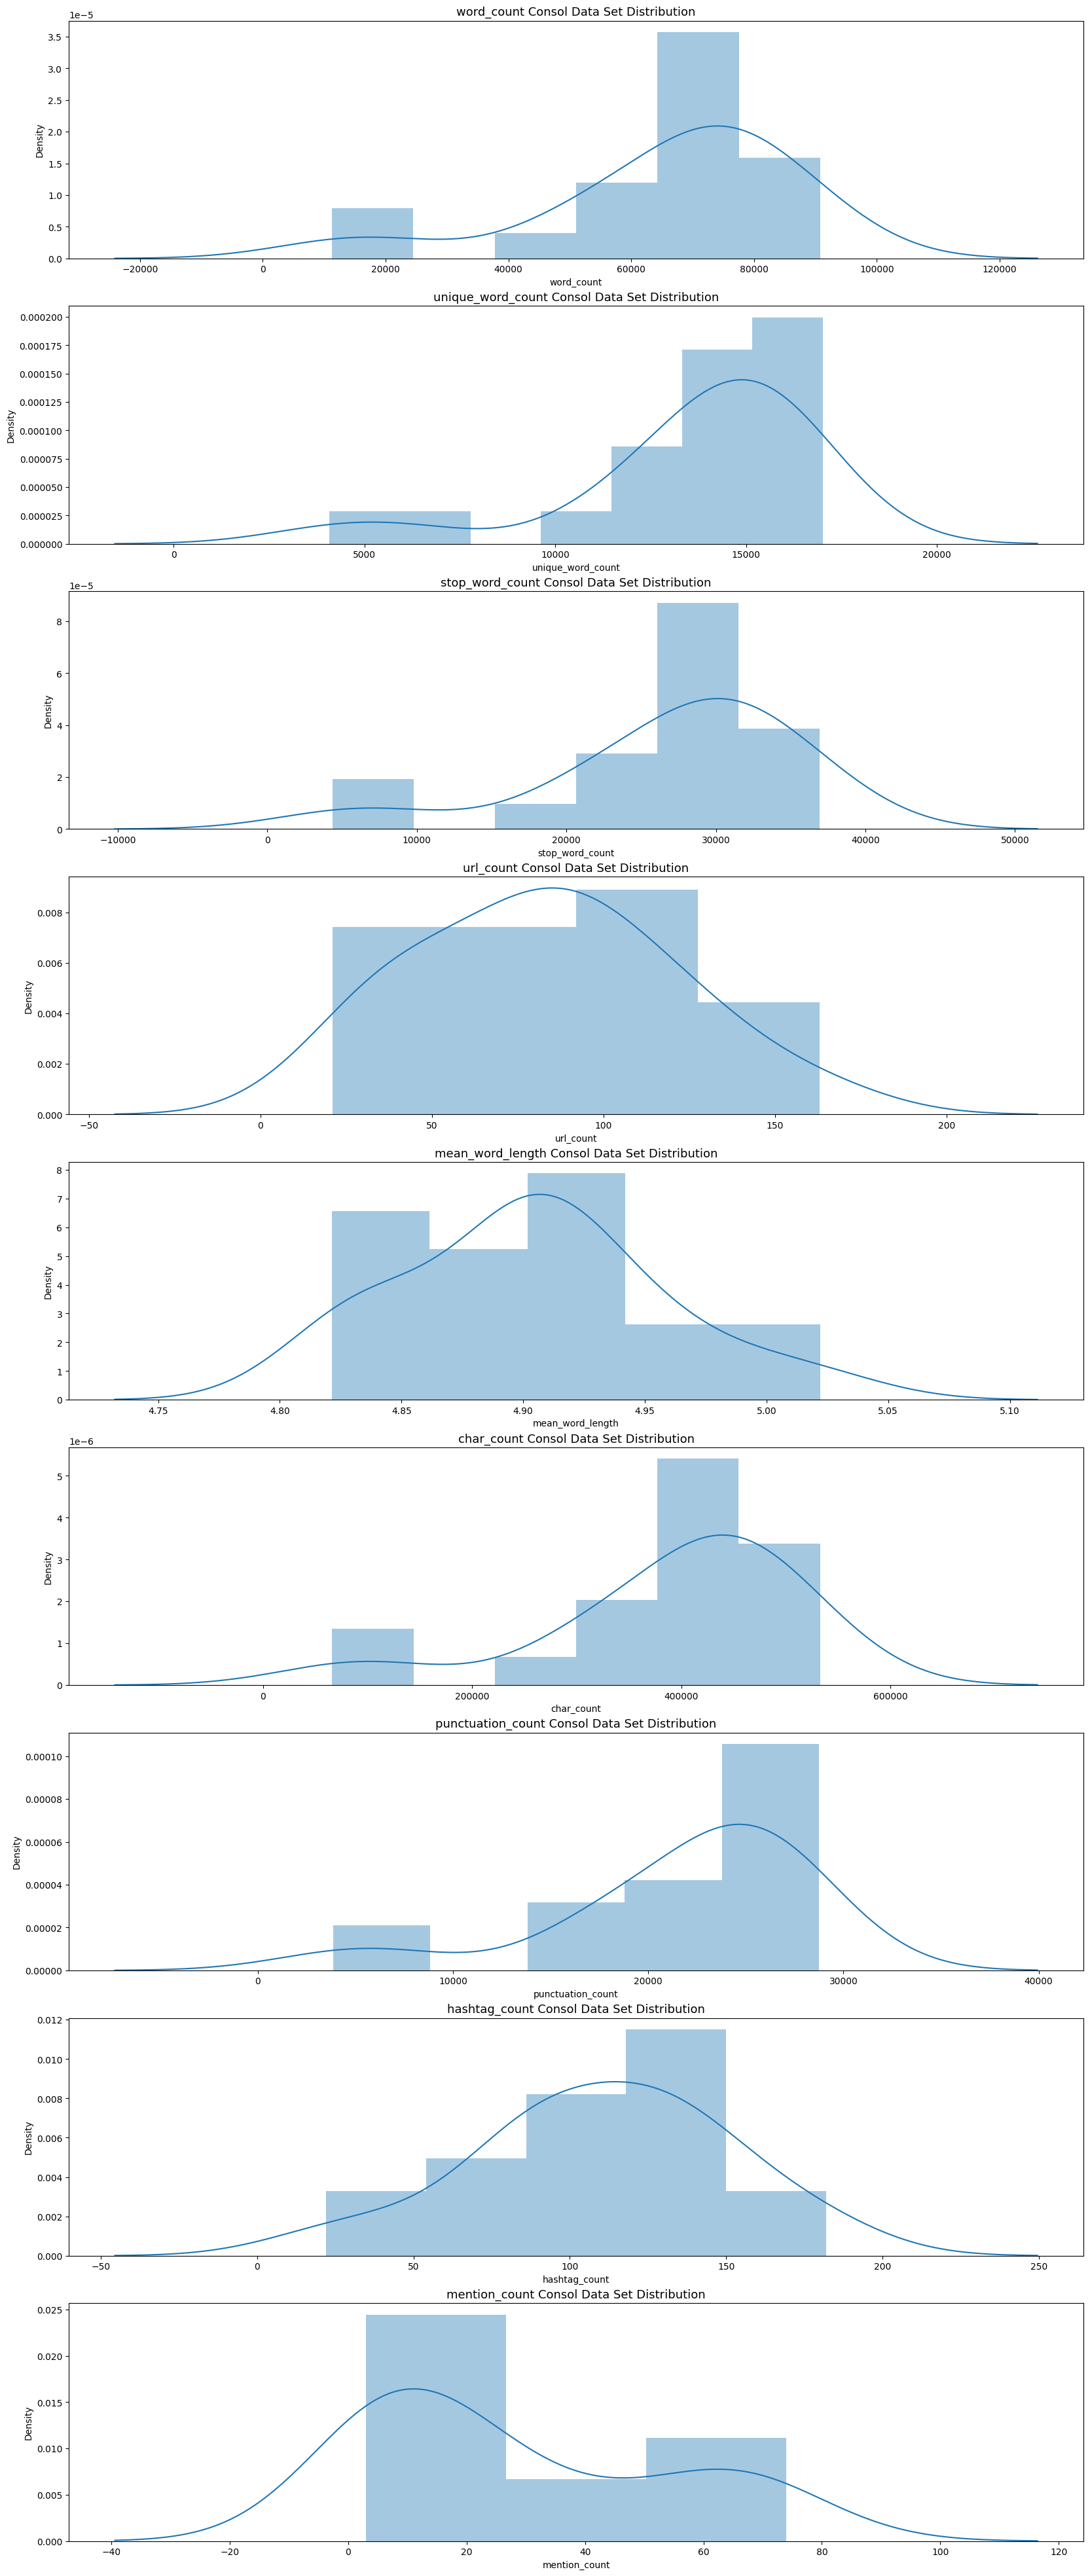

In [8]:
import warnings
warnings.filterwarnings("ignore")

# visualisation of meta features

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):

    sns.distplot(consol_df[feature], label='Consol', ax=axes[i])

    axes[i].set_title(f'{feature} Consol Data Set Distribution', fontsize=13)

plt.show()

## 1.2. Embeddings coverage

In [11]:
#Load the 2 popular embedding
#glove
#fasttext

fasttext_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/crawl-300d-2M-002-001.pkl', allow_pickle=True)
glove_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/glove.840B.300d-001-002.pkl', allow_pickle=True)

In [12]:
# Embeddings Coverage

# break the comments into words
# vocab is the unique words in the text data
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for comment in comments:
        for word in comment:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

consol_glove_oov, consol_glove_vocab_coverage, consol_glove_text_coverage = check_embeddings_coverage(consol_df['comments'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_glove_vocab_coverage, consol_glove_text_coverage))

consol_fasttext_oov, consol_fasttext_vocab_coverage, consol_fasttext_text_coverage = check_embeddings_coverage(consol_df['comments'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_fasttext_vocab_coverage, consol_fasttext_text_coverage))

GloVe Embeddings cover 44.71% of vocabulary and 86.95% of text in Consol Set
FastText Embeddings cover 48.02% of vocabulary and 89.00% of text in Consol Set


## 1.3. N-gram analysis (for sentiment analysis)

In [ ]:
# 3. Ngrams(rank Ngrams in both labels)
# understand the info of Ngrams

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
consol_unigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt):
        consol_unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(consol_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
consol_bigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams[word] += 1

df_bigrams = pd.DataFrame(sorted(consol_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
consol_trigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams[word] += 1

df_trigrams = pd.DataFrame(sorted(consol_trigrams.items(), key=lambda x: x[1])[::-1])

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129292 (\N{PINCHED FINGERS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


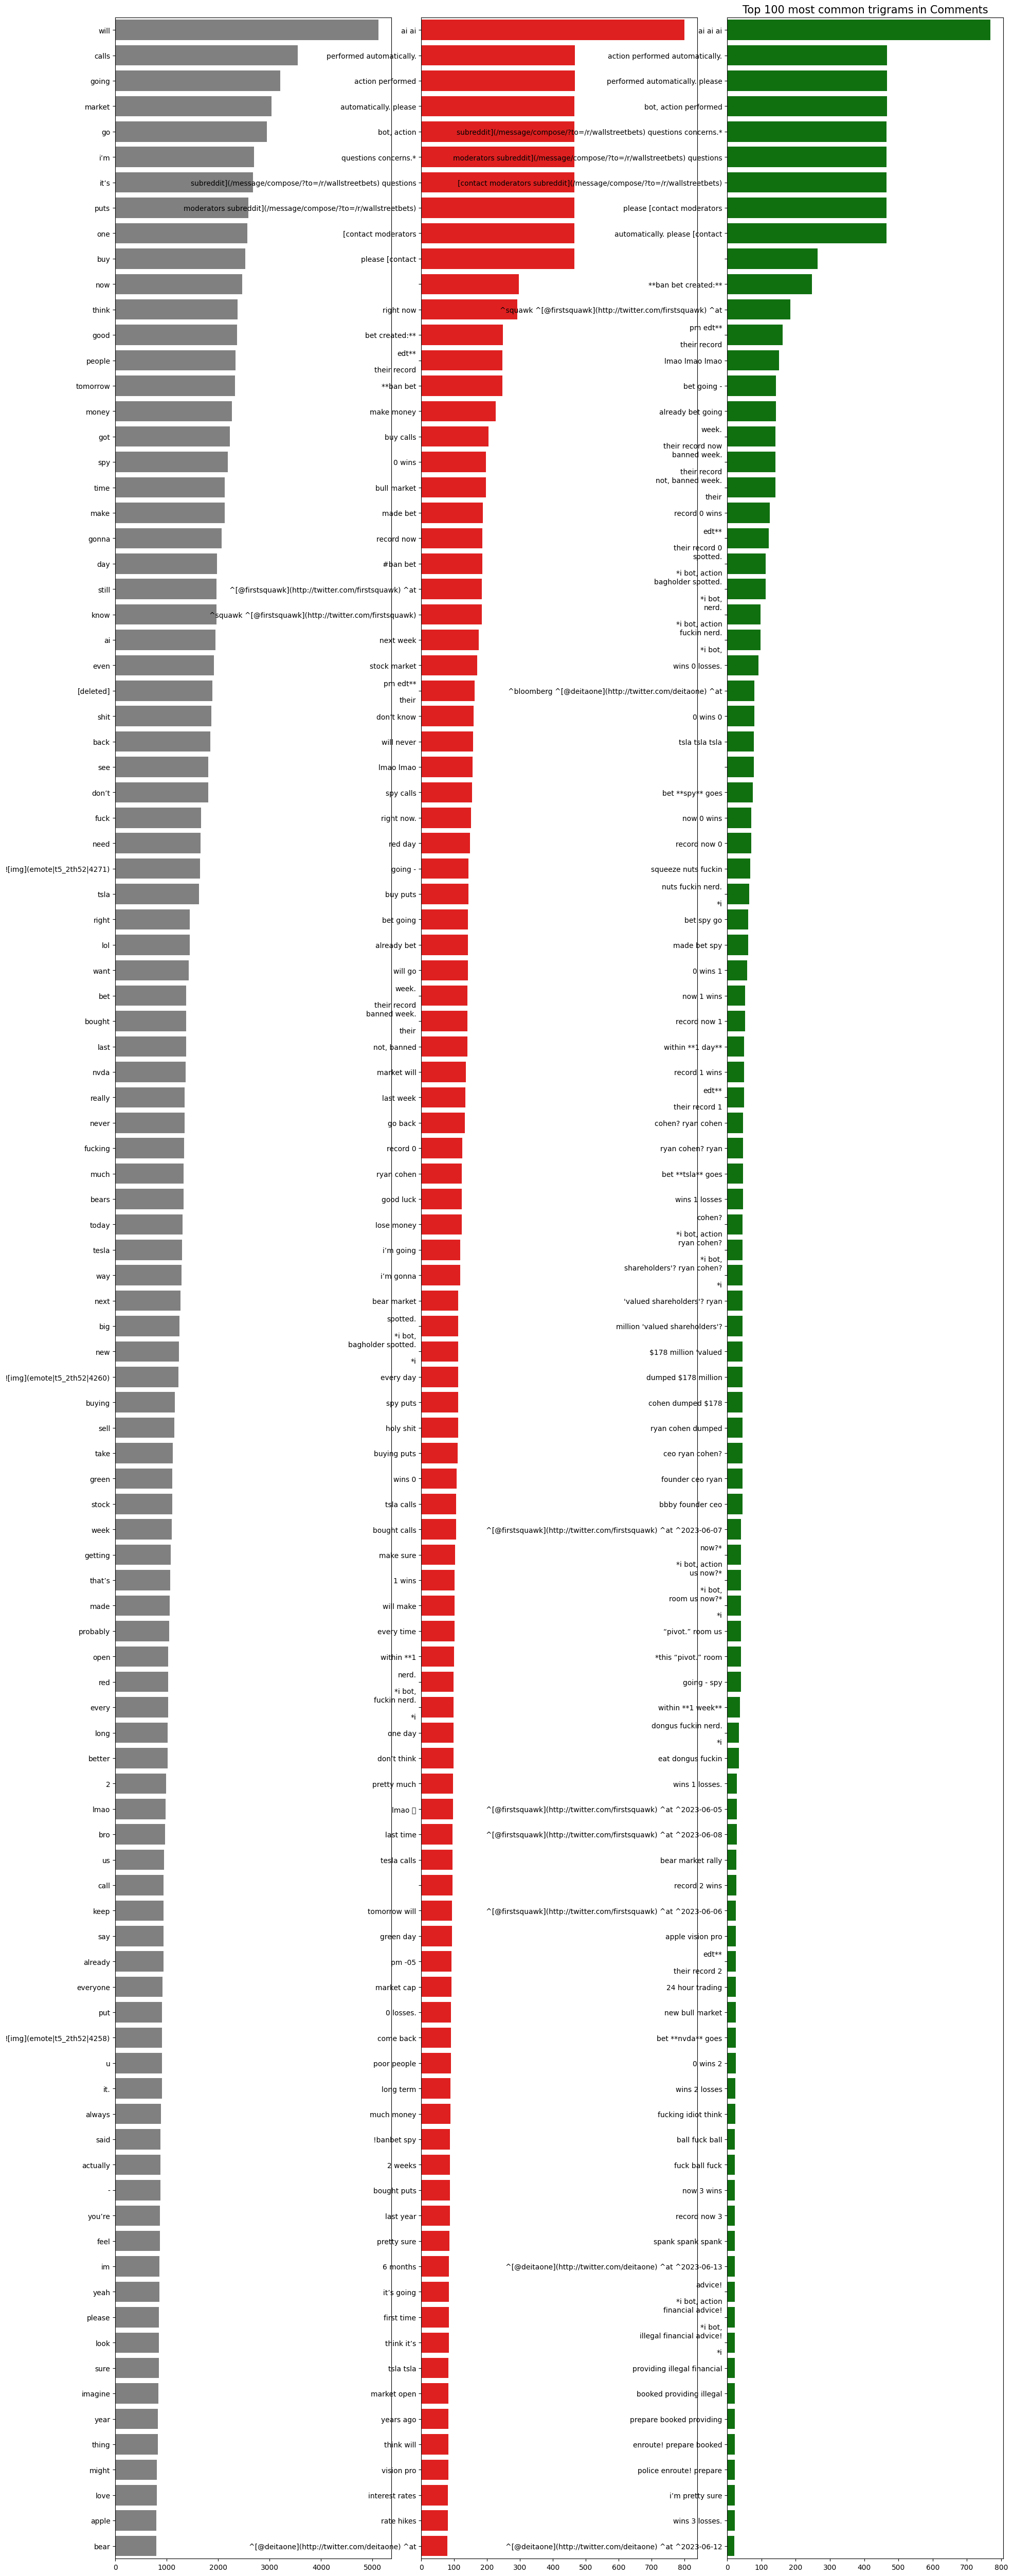

In [ ]:
# 3. Ngrams
# visualisation for Unigrams
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Comments', fontsize=15)

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Comments', fontsize=15)

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Comments', fontsize=15)

plt.show()

## 3. Data processing
  1. clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  - option 3: spaCy (by Jun)
  2. clean the text with embedding (Glove/ Fasttext) - for sentiment analysis
  - Load the 2 popular embedding
  - Embeddings Coverage
  - generating the oov -> then check coverage
  - (optional) generate embeddings for constituent character n-grams of oovs
  - clean the text -> then check coverage
  3. Prepare the Training dataset
  - option 1: Generate the list of keywords
  - option 2: Generate the list of N-grams
  - option 3: score for sentiment analysis (by Jun)
  - check for Duplicated labeled records


## 3.1 clean the comments with neutral words


In [ ]:
# option 1: NLTK - stop words

import nltk
from nltk.corpus import stopwords

In [ ]:
# option 1: NLTK - stop words
# to clean the date set

text = "When I first met her she was very quiet. She remained quiet during the entire two hour long journey from Stony Brook to New York."
words = [word for word in text.split() if word.lower() not in sw_nltk]
new_text = " ".join(words)
print(new_text)
print("Old length: ", len(text))
print("New length: ", len(new_text))

In [ ]:
# option 2: SK learn - ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

In [ ]:
# option 2: SK learn - ENGLISH_STOP_WORDS
# to clean the date set

words = [word for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS]
new_text = " ".join(words)
print(new_text)
print("Old length: ", len(text))
print("New length: ", len(new_text))

## 3.2. clean the text with embedding (Glove/ Fasttext) - for sentiment analysis

In [ ]:
#1. clean the text with embedding
#Load the 2 popular embedding
#glove
#fasttext

# 讀取pickle文件
glove_embeddings = np.load('/content/drive/MyDrive/CUSCS - Group project/ML-NLP-Embeddings/crawl-300d-2M-002.pkl', allow_pickle=True)
fasttext_embeddings = np.load('/content/drive/MyDrive/CUSCS - Group project/ML-NLP-Embeddings/glove.840B.300d-001.pkl', allow_pickle=True)


"\n#Load the 2 popular embedding\n#glove\n#fasttext\n\n# 讀取pickle文件\nglove_embeddings = np.load('/content/drive/MyDrive/CUSCS - Group project/ML-NLP-Embeddings/crawl-300d-2M-002.pkl', allow_pickle=True)\nfasttext_embeddings = np.load('/content/drive/MyDrive/CUSCS - Group project/ML-NLP-Embeddings/glove.840B.300d-001.pkl', allow_pickle=True)\n"

In [ ]:
#1. clean the text with embedding
# Embeddings Coverage

# break the comment into words
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for cmt in comments:
        for word in cmt:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['comments'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['comments'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))



"\n# Embeddings Coverage\n\n# break the comment into words\ndef build_vocab(X):\n\n    comments = X.apply(lambda s: s.split()).values\n    vocab = {}\n\n    for cmt in comments:\n        for word in cmt:\n            try:\n                vocab[word] += 1\n            except KeyError:\n                vocab[word] = 1\n    return vocab\n\n\ndef check_embeddings_coverage(X, embeddings):\n\n    vocab = build_vocab(X)\n\n    covered = {}\n    oov = {}\n    n_covered = 0\n    n_oov = 0\n\n    for word in vocab:\n        try:\n            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量\n            n_covered += vocab[word]\n        except:\n            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋\n            n_oov += vocab[word]\n\n    #calculate the coverage\n    vocab_coverage = len(covered) / len(vocab)\n    text_coverage = (n_covered / (n_covered + n_oov))\n\n    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回\n    sorted_oov = sorted(oov.items(), key

In [ ]:
# 1. clean the text with embedding
# generating the oov
# The purpose of generating Out-of-Vocabulary (OOV) embeddings using FastText is to provide vector representations
# - for words that are not present in the original vocabulary of the pre-trained FastText model.
# combination of character n-grams, which allows it to
# - capture the meaning of words even if they are out-of-vocabulary or misspelled.
# OOV words can negatively impact the performance of the model, and having embeddings
# - for these words can help improve the accuracy and robustness of the model.

# lump the 2 oov list as one
mergedlist = glove_oov + fasttext_oov

# 將新列表轉換為集合，這將刪除重複的元素
unique_set = set(mergedlist)

# 將集合轉換為列表，以便返回
total_oov = list(unique_set)
df_total_oov = pd.DataFrame(total_oov)

# save as new CSV
df_total_oov.to_csv('total_oov.csv')

print(f"The counts of records in Glove OOV list is {len(glove_oov)}")
print(f"The counts of records in Fasttest OOV list is {len(fasttext_oov)}")
print(f"The counts of records in Total OOV list is {len(total_oov)}")


'\n# read the oov and see how to further clean\n\n# lump the 2 oov list as one\nmergedlist = glove_oov + fasttext_oov\n\n# 將新列表轉換為集合，這將刪除重複的元素\nunique_set = set(mergedlist)\n\n# 將集合轉換為列表，以便返回\ntotal_oov = list(unique_set)\ndf_total_oov = pd.DataFrame(total_oov)\n\n# save as new CSV\ndf_total_oov.to_csv(\'total_oov.csv\')\n\nprint(f"The counts of records in Glove OOV list is {len(glove_oov)}")\nprint(f"The counts of records in Fasttest OOV list is {len(fasttext_oov)}")\nprint(f"The counts of records in Total OOV list is {len(total_oov)}")\n'

In [ ]:
# 1. clean the text with embedding
# clean the text
# then check coverage on the cleaned text again

%%time

def clean(comment):

    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)
    comment = re.sub(r"donå«t", "do not", comment)

    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"USAgov", "USA government", comment)
    comment = re.sub(r"recentlu", "recently", comment)
    comment = re.sub(r"Ph0tos", "Photos", comment)
    comment = re.sub(r"amirite", "am I right", comment)
    comment = re.sub(r"exp0sed", "exposed", comment)
    comment = re.sub(r"<3", "love", comment)
    comment = re.sub(r"amageddon", "armageddon", comment)
    comment = re.sub(r"Trfc", "Traffic", comment)
    comment = re.sub(r"8/5/2015", "2015-08-05", comment)
    comment = re.sub(r"WindStorm", "Wind Storm", comment)
    comment = re.sub(r"8/6/2015", "2015-08-06", comment)
    comment = re.sub(r"10:38PM", "10:38 PM", comment)
    comment = re.sub(r"10:30pm", "10:30 PM", comment)
    comment = re.sub(r"16yr", "16 year", comment)
    comment = re.sub(r"lmao", "laughing my ass off", comment)
    comment = re.sub(r"TRAUMATISED", "traumatized", comment)

    # Urls
    comment = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", comment)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        comment = comment.replace(p, ' ')

    # ... and ..
    # 在這個例子中，如果省略號已經被替換為 " ... "，那麼後續使用 replace() 方法替換 ".." 會失效，因為 "..." 中已經包含了兩個點。
    comment = comment.replace('...', ' ')
    if '...' not in comment:
         comment = comment.replace('..', ' ... ')

    # Grouping same words without embeddings
    comment = re.sub(r"Bestnaijamade", "bestnaijamade", comment)
    comment = re.sub(r"SOUDELOR", "Soudelor", comment)

    return comment

consol_df['comments_cleaned'] = consol_df['comments'].apply(lambda s : clean(s))
'''
glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))
'''

CPU times: user 1.54 s, sys: 3.95 ms, total: 1.55 s
Wall time: 1.93 s


"\nglove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned'], glove_embeddings)\nprint('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))\n\nfasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned'], fasttext_embeddings)\nprint('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))\n"

In [ ]:
# 1. clean the text with embedding
# save a copy of clean text
'''
consol_df.to_csv('consol_df.csv')
'''

"\n\nconsol_df.to_csv('consol_df.csv')\n"

In [ ]:
# 1. clean the text with embedding
# After cleaning, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
'''
del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()
'''

'\ndel glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,\ngc.collect()\n'

In [ ]:
# 1. clean the text with embedding
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned = defaultdict(int)

for cmt in consol_df['comments_cleaned']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned[word] += 1

df_unigrams_cleaned = pd.DataFrame(sorted(consol_unigrams_cleaned.items(), key=lambda x: x[1])[::-1],  columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned = defaultdict(int)

for cmt in consol_df['comments_cleaned']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned[word] += 1

df_bigrams_cleaned = pd.DataFrame(sorted(consol_bigrams_cleaned.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned = defaultdict(int)

for cmt in consol_df['comments_cleaned']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned[word] += 1

df_trigrams_cleaned = pd.DataFrame(sorted(consol_trigrams_cleaned.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_unigrams_cleaned

,grams,count
0,emote,23064
1,img,22653
2,t5_2th52,22640
3,will,6203
4,4271,4317
...,...,...
58350,later\n\n,1
58351,\n0dte,1
58352,"early”,",1
58353,😃🍆,1


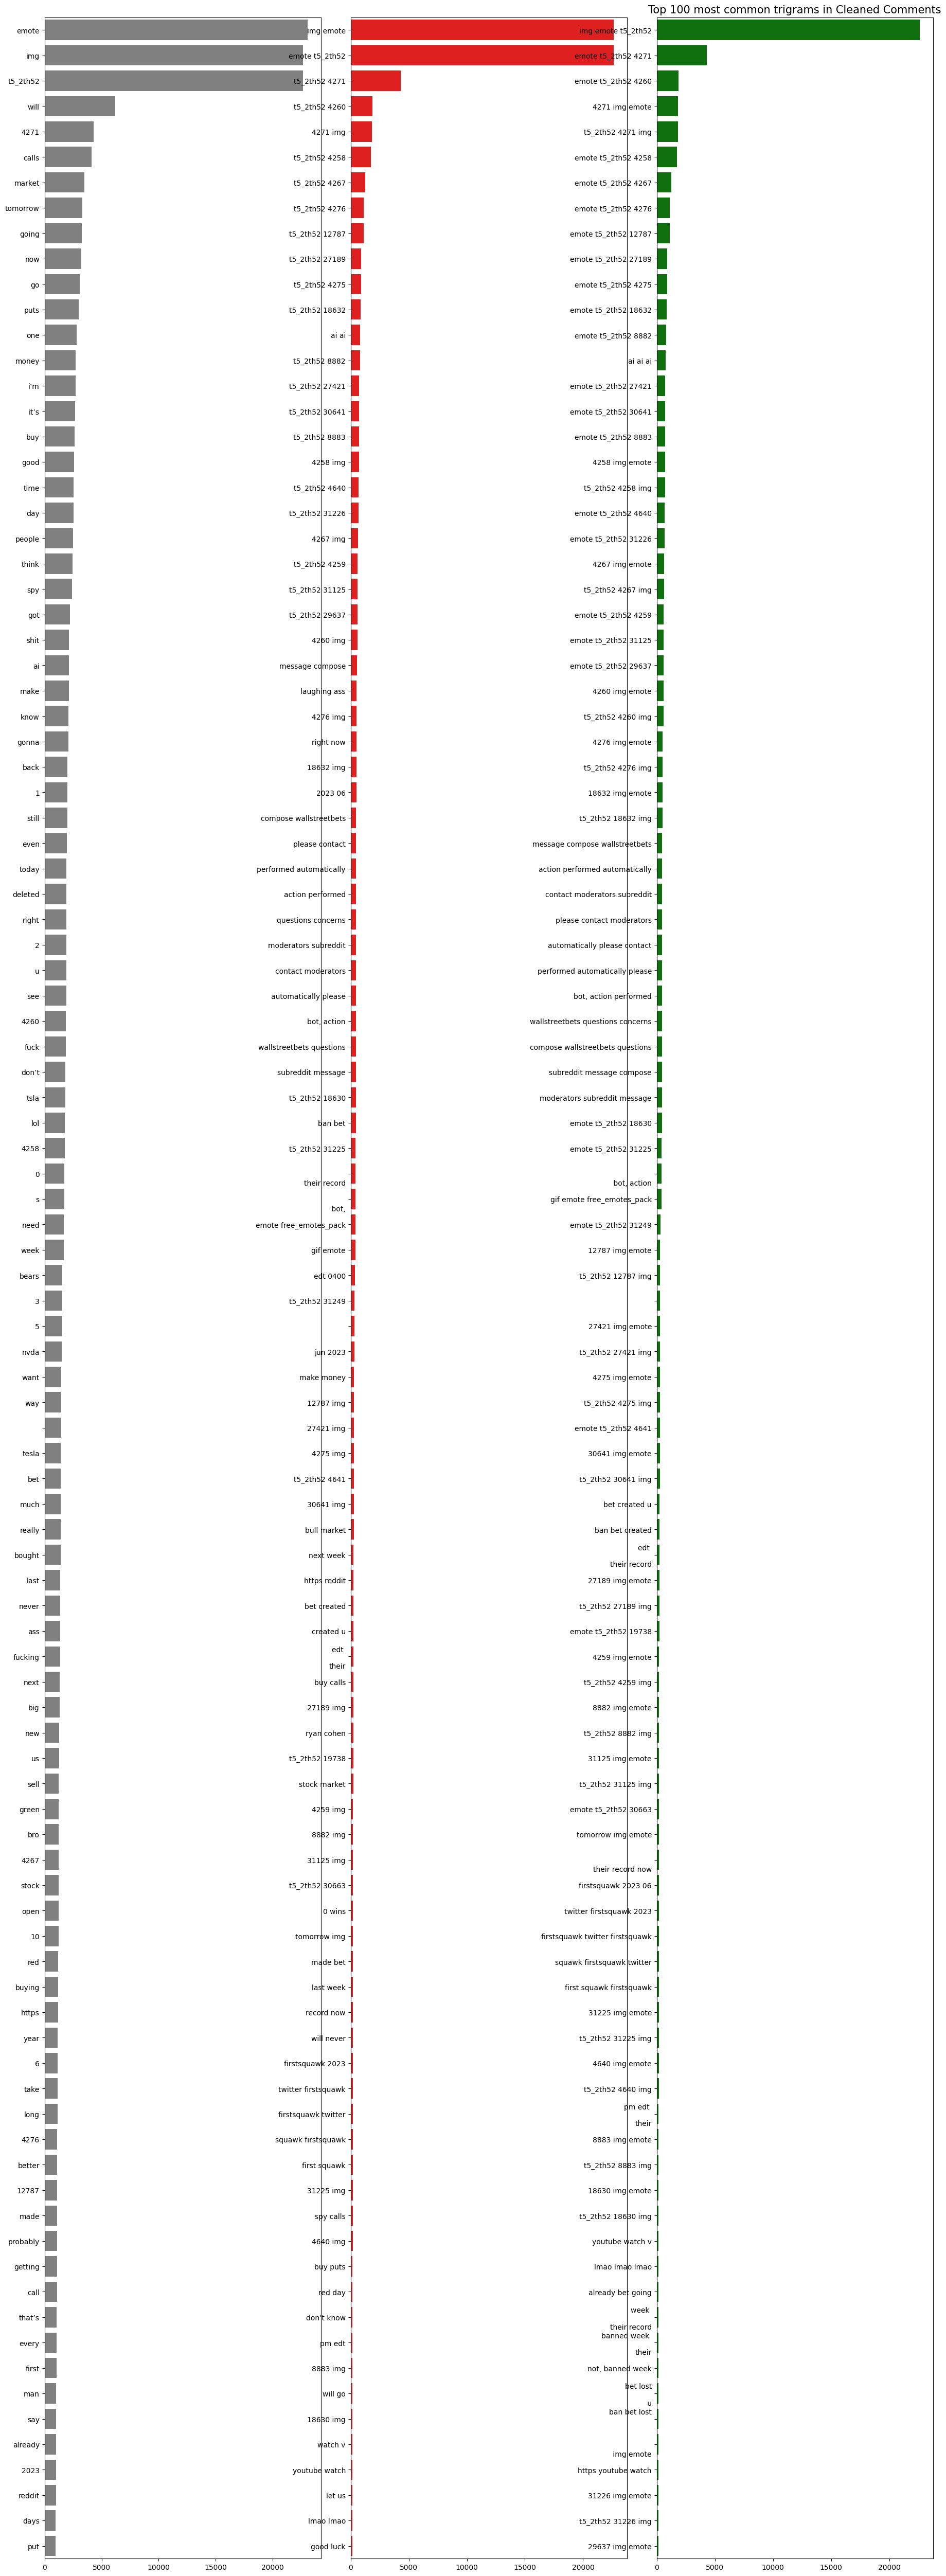

In [ ]:
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned['grams'].values[:N], x=df_unigrams_cleaned['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments', fontsize=15)

sns.barplot(y=df_bigrams_cleaned['grams'].values[:N], x=df_bigrams_cleaned['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments', fontsize=15)

sns.barplot(y=df_trigrams_cleaned['grams'].values[:N], x=df_trigrams_cleaned['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments', fontsize=15)

plt.show()

In [ ]:
# 2nd round cleaned
# criteria: by reading the ranking

# Words with punctuations and special characters

%%time

def clean_second(comment):

    comment = re.sub(r"emote", " ", comment)
    comment = re.sub(r"img", " ", comment)
    comment = re.sub(r"t5_2th52", " ", comment)

    return comment

consol_df['comments_cleaned_second'] = consol_df['comments_cleaned'].apply(lambda s : clean_second(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned_second'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 2nd clean'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned_second'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 2nd clean'.format(fasttext_vocab_coverage, fasttext_text_coverage))

CPU times: user 127 ms, sys: 671 µs, total: 128 ms
Wall time: 139 ms


In [ ]:
# 2nd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['comments_cleaned_second']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_second[word] += 1

df_unigrams_cleaned_second = pd.DataFrame(sorted(consol_unigrams_cleaned_second.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['comments_cleaned_second']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_second[word] += 1

df_bigrams_cleaned_second = pd.DataFrame(sorted(consol_bigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['comments_cleaned_second']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_second[word] += 1

df_trigrams_cleaned_second = pd.DataFrame(sorted(consol_trigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_unigrams_cleaned_second

In [ ]:
# 2nd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_second['grams'].values[:N], x=df_unigrams_cleaned_second['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_second['grams'].values[:N], x=df_bigrams_cleaned_second['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_second['grams'].values[:N], x=df_trigrams_cleaned_second['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 2nd clean', fontsize=15)

plt.show()

## 3.3. Prepare the Training dataset

In [ ]:
# option 2: Generate the list of N-grams
df_unigrams_cleaned_second_tomerge = df_unigrams_cleaned_second[:100]

df_bigrams_cleaned_second_tomerge = df_bigrams_cleaned_second[:100]

df_trigrams_cleaned_second_tomerge = df_trigrams_cleaned_second[:100]

df_unigrams_cleaned_second_tomerge

,grams,count
0,will,6203
1,4271,4317
2,calls,4114
3,market,3472
4,tomorrow,3323
...,...,...
95,days,981
96,put,977
97,yeah,974
98,thing,967


In [ ]:
# option 2: Generate the list of N-grams
# create a series contiaing first 100 unigram, bigram , trigram

list_top100gram = pd.concat([df_unigrams_cleaned_second_tomerge['grams'] , df_bigrams_cleaned_second_tomerge['grams'] , df_trigrams_cleaned_second_tomerge['grams']], axis=0)
list_top100gram

0                   will
1                   4271
2                  calls
3                 market
4               tomorrow
             ...        
95    \n\ntheir record 1
96           jun 2023 04
97            2023 06 06
98      cohen ryan cohen
99       ryan cohen ryan
Name: grams, Length: 300, dtype: object

In [ ]:
# option 2: Generate the list of N-grams
# create a df containings n columns each with 1 key word, each row of record shows the count of frequency of each keyword in the raw text

df_top100gram = pd.DataFrame(columns=list_top100gram, index=consol_df.index)
for i, row in consol_df.iterrows():
    for gram in list_top100gram:
        count = row['comments_cleaned_second'].count(gram)
        df_top100gram.at[i, gram] = count

df_top100gram['title'] = consol_df['title']
df_top100gram

grams,will,4271,calls,market,tomorrow,going,now,go,puts,one,...,record now 1,2023 06 13,within 1 day,record 1 wins,\n\ntheir record 1,jun 2023 04,2023 06 06,cohen ryan cohen,ryan cohen ryan,title
0,423,240,288,348,200,212,402,1117,198,735,...,0,0,0,0,0,0,0,0,0,"What Are Your Moves Tomorrow, June 15, 2023"
1,443,310,277,265,262,223,408,1108,219,739,...,0,12,0,0,0,0,2,0,0,"What Are Your Moves Tomorrow, June 14, 2023"
2,497,264,263,381,278,209,423,1065,235,838,...,0,34,0,0,0,0,0,0,0,"What Are Your Moves Tomorrow, June 13, 2023"
3,236,205,177,151,99,159,246,748,82,521,...,0,0,0,0,0,0,0,0,0,"What Are Your Moves Tomorrow, June 12, 2023"
4,323,271,281,266,282,214,348,942,190,614,...,0,0,0,0,0,0,0,0,0,"What Are Your Moves Tomorrow, June 09, 2023"
5,339,329,193,159,186,164,351,977,166,590,...,0,0,0,0,0,0,0,0,0,"What Are Your Moves Tomorrow, June 08, 2023"
6,312,204,217,216,161,171,405,893,160,658,...,0,3,0,0,0,0,32,0,0,"What Are Your Moves Tomorrow, June 07, 2023"
7,401,215,185,166,114,154,366,975,171,648,...,0,0,0,0,0,0,13,0,0,"What Are Your Moves Tomorrow, June 06, 2023"
8,58,26,34,26,11,16,37,143,26,108,...,0,2,0,0,0,0,1,0,0,"What Are Your Moves Tomorrow, June 06, 2023"
9,108,100,75,63,45,40,85,269,43,179,...,0,0,0,0,0,0,0,0,0,"What Are Your Moves Tomorrow, June 06, 2023"


In [ ]:
# option 2: Generate the list of N-grams
#back up the training data set

df_top100gram.to_csv('df_top100gram_Jun_testing.csv')

In [ ]:
# 2. Prepare the Training dataset
# Check for Duplicated labeled records
'''
# extract the list of "text"
df_mislabeled = consol_df.groupby(['comments']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

'''

'\n# extract the list of "text"\ndf_mislabeled = consol_df.groupby([\'comments\']).nunique().sort_values(by=\'target\', ascending=False)\ndf_mislabeled = df_mislabeled[df_mislabeled[\'target\'] > 1][\'target\']\ndf_mislabeled.index.tolist()\n\n'

In [ ]:
# Check for Duplicated labeled records
# review and relabel the text one by one

what if the keyword is new and never trained before in model?
- Ngrams & embeddings


In [ ]:
'''
# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證
# 為了確保每個子集都能夠代表整個資料集的類別分佈
K = 3
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = train_df['target'] == 1
print('Whole Training Set Shape = {}'.format(train_df.shape))
print('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))

#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列
# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合
# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, train_df.loc[trn_idx, 'keyword'].nunique(), train_df.loc[val_idx, 'keyword'].nunique()))


'''

"\n# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證\n# 為了確保每個子集都能夠代表整個資料集的類別分佈\nK = 3\nskf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)\n\nDISASTER = train_df['target'] == 1\nprint('Whole Training Set Shape = {}'.format(train_df.shape))\nprint('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))\nprint('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))\n\n#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列\n# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合\n# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證\nfor fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):\n    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'tex